In [37]:
import numpy as np
import pandas as pd

### 데이터 불러오기

In [39]:
train  = pd.read_csv('./data/train.csv')
test  = pd.read_csv('./data/test.csv')

train = train.drop(['index'],axis = 1)
test =test.drop(['index'],axis = 1)

### 데이터 전처리(응답시간)

In [40]:
concat_features = train

mask = concat_features.introelapse > (concat_features.introelapse.quantile(0.75) + 
    1.5 * (concat_features.introelapse.quantile(0.75) - 
    concat_features.introelapse.quantile(0.25)))
    
concat_features.introelapse[mask] = concat_features.introelapse.quantile(0.75)

mask = concat_features.testelapse > (concat_features.testelapse.quantile(0.75) + 1.5 * (concat_features.testelapse.quantile(0.75) - concat_features.testelapse.quantile(0.25)))
concat_features.testelapse[mask] = concat_features.testelapse.quantile(0.75)

mask = concat_features.surveyelapse > (concat_features.surveyelapse.quantile(0.75) + 1.5 * (concat_features.surveyelapse.quantile(0.75) - concat_features.surveyelapse.quantile(0.25)))
concat_features.surveyelapse[mask] = concat_features.surveyelapse.quantile(0.75)

train = concat_features



concat_features = test

mask = concat_features.introelapse > (concat_features.introelapse.quantile(0.75) + 1.5 * (concat_features.introelapse.quantile(0.75) - concat_features.introelapse.quantile(0.25)))
concat_features.introelapse[mask] = concat_features.introelapse.quantile(0.75)

mask = concat_features.testelapse > (concat_features.testelapse.quantile(0.75) + 1.5 * (concat_features.testelapse.quantile(0.75) - concat_features.testelapse.quantile(0.25)))
concat_features.testelapse[mask] = concat_features.testelapse.quantile(0.75)

mask = concat_features.surveyelapse > (concat_features.surveyelapse.quantile(0.75) + 1.5 * (concat_features.surveyelapse.quantile(0.75) - concat_features.surveyelapse.quantile(0.25)))
concat_features.surveyelapse[mask] = concat_features.surveyelapse.quantile(0.75)

test = concat_features


### 데이터 전처리(나이)

In [41]:
train.loc[train['age'] == 0, 'age'] = train['age'].mean()
test.loc[test['age'] == 0, 'age'] = train['age'].mean()

In [42]:
train.loc[train['age'] > 65, 'age'] = 0
test.loc[test['age'] > 65, 'age'] = 0

### 데이터 전처리(가족 수)

In [43]:
train.loc[train['familysize'] > 6, 'familysize'] = train['familysize'].mode()[0]
test.loc[test['familysize'] > 6, 'familysize'] = train['familysize'].mode()[0]

### 파라미터 값 조정(원 핫 인코딩)

In [44]:
for name in ['education', 'urban', 'gender', 'engnat', 'hand', 'religion',
            'voted', 'married']:

    mergedata = pd.get_dummies(train[name], prefix = name)
    train = pd.concat([train, mergedata], axis=1)
    train = train.drop([name], axis = 1)

In [45]:
for name in ['education', 'urban', 'gender', 'engnat', 'hand', 'religion',
            'voted', 'married']:

    mergedata = pd.get_dummies(test[name], prefix = name)
    test = pd.concat([test, mergedata], axis=1)
    test = test.drop([name], axis = 1)

### 데이터 전처리(나라 - 라벨인코딩)

In [47]:
from sklearn.preprocessing import LabelEncoder
ex = LabelEncoder()

con8 = train.country.value_counts().keys()[:6]

for i in range(train.count().max()):
    if(train.country.values[i] not in con8):
        train.country.values[i] = "X"

for i in range(test.count().max()):
    if(test.country.values[i] not in con8):
        test.country.values[i] = "X"

train.country = ex.fit_transform(train.country)

test.country = ex.fit_transform(test.country)

### pycaret 모델 학습

### setting

In [49]:
from pycaret.classification import *

model = setup(data = train, target = 'nerdiness',use_gpu=True,session_id=2023, normalize = True, normalize_method = 'zscore',transformation=True,train_size=0.85)

,Description,Value
0,session_id,2023
1,Target,nerdiness
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(15000, 94)"
5,Missing Values,True
6,Numeric Features,38
7,Categorical Features,55
8,Ordinal Features,False
9,High Cardinality Features,False


### 모델 비교

In [50]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7853,0.8744,0.8464,0.7849,0.8145,0.5606,0.5629,1.0040
rf,Random Forest Classifier,0.7840,0.8688,0.8456,0.7837,0.8134,0.5578,0.5602,0.8550
catboost,CatBoost Classifier,0.7634,0.8327,0.8253,0.7674,0.7952,0.5158,0.5179,7.4580
xgboost,Extreme Gradient Boosting,0.7616,0.8299,0.8143,0.7708,0.7918,0.5135,0.5147,0.7620
lightgbm,Light Gradient Boosting Machine,0.7486,0.8219,0.8109,0.7556,0.7822,0.4858,0.4876,1.1090
gbc,Gradient Boosting Classifier,0.7322,0.8025,0.8002,0.7400,0.7689,0.4517,0.4538,6.1400
lr,Logistic Regression,0.7295,0.7987,0.7892,0.7418,0.7647,0.4475,0.4487,1.4230
ridge,Ridge Classifier,0.7287,0.0000,0.7922,0.7394,0.7648,0.4452,0.4467,0.0890
lda,Linear Discriminant Analysis,0.7285,0.7981,0.7919,0.7393,0.7646,0.4449,0.4464,0.4700
ada,Ada Boost Classifier,0.7242,0.7926,0.7837,0.7375,0.7598,0.4367,0.4379,1.9030


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=2023, verbose=0,
                     warm_start=False)

### 모델 생성

In [51]:
rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7788,0.8658,0.8268,0.7869,0.8063,0.5489,0.5498
1,0.7945,0.8836,0.8465,0.7971,0.8210,0.5803,0.5817
2,0.7992,0.8880,0.8549,0.7987,0.8259,0.5895,0.5914
3,0.7765,0.8717,0.8451,0.7742,0.8081,0.5417,0.5447
4,0.7671,0.8623,0.8465,0.7617,0.8019,0.5212,0.5255
5,0.7812,0.8577,0.8465,0.7795,0.8116,0.5517,0.5543
6,0.7867,0.8660,0.8521,0.7837,0.8165,0.5628,0.5657
7,0.7843,0.8603,0.8519,0.7804,0.8146,0.5580,0.5611
8,0.7843,0.8617,0.8420,0.7855,0.8128,0.5591,0.5610


In [52]:
et = create_model('et')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7835,0.8709,0.8423,0.7848,0.8125,0.5572,0.5592
1,0.7961,0.8850,0.8493,0.7976,0.8226,0.5833,0.5849
2,0.8016,0.8923,0.8479,0.8059,0.8264,0.5952,0.5963
3,0.7859,0.8774,0.8521,0.7827,0.8159,0.5612,0.5641
4,0.7718,0.8691,0.8437,0.7689,0.8046,0.5317,0.5350
5,0.7694,0.8667,0.8352,0.7701,0.8014,0.5277,0.5301
6,0.7875,0.8693,0.8521,0.7847,0.8170,0.5645,0.5673
7,0.7859,0.8728,0.8491,0.7839,0.8152,0.5617,0.5642
8,0.7867,0.8660,0.8491,0.7849,0.8157,0.5634,0.5658


In [53]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7537,0.8205,0.7972,0.7690,0.7828,0.4986,0.4991
1,0.7576,0.8363,0.8014,0.7720,0.7865,0.5065,0.5070
2,0.7733,0.8451,0.8380,0.7737,0.8046,0.5358,0.5382
3,0.7545,0.8299,0.8183,0.7595,0.7878,0.4976,0.4995
4,0.7278,0.8130,0.8085,0.7312,0.7679,0.4410,0.4442
5,0.7318,0.8057,0.7944,0.7421,0.7673,0.4515,0.4530
6,0.7459,0.8150,0.8155,0.7500,0.7814,0.4793,0.4817
7,0.7333,0.8099,0.7969,0.7424,0.7687,0.4548,0.4564
8,0.7451,0.8089,0.8152,0.7487,0.7806,0.4778,0.4803


### 모델 세가지 여러 방식으로 앙상블

In [54]:
blended1 = blend_models(estimator_list = [et,rf], fold = 10, method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7851,0.8721,0.8394,0.7884,0.8131,0.5609,0.5624
1,0.8055,0.8878,0.8592,0.8047,0.8311,0.6024,0.6042
2,0.8063,0.8935,0.8592,0.8058,0.8316,0.6041,0.6058
3,0.7827,0.8789,0.8493,0.7801,0.8132,0.5547,0.5576
4,0.7655,0.8699,0.8437,0.7611,0.8003,0.5181,0.5222
5,0.7765,0.8657,0.8507,0.7714,0.8091,0.5410,0.5448
6,0.7827,0.8712,0.8493,0.7801,0.8132,0.5547,0.5576
7,0.7859,0.8709,0.8561,0.7802,0.8164,0.5609,0.5644
8,0.7843,0.8682,0.8547,0.7789,0.8151,0.5577,0.5612


In [55]:
blended2 = blend_models(estimator_list = [lightgbm,et], fold = 10, method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7851,0.8672,0.8296,0.7938,0.8113,0.5620,0.5628
1,0.8016,0.8829,0.8338,0.8143,0.8239,0.5967,0.5969
2,0.8063,0.8916,0.8577,0.8066,0.8314,0.6043,0.6058
3,0.7961,0.8755,0.8704,0.7863,0.8262,0.5811,0.5855
4,0.7757,0.8667,0.8563,0.7677,0.8096,0.5387,0.5434
5,0.7749,0.8619,0.8366,0.7765,0.8054,0.5393,0.5414
6,0.7827,0.8643,0.8479,0.7808,0.8130,0.5549,0.5576
7,0.7875,0.8656,0.8491,0.7859,0.8163,0.5651,0.5674
8,0.7851,0.8618,0.8505,0.7821,0.8149,0.5599,0.5627


In [56]:
blended3 = blend_models(estimator_list = [lightgbm,rf], fold = 10, method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7757,0.8545,0.8282,0.7819,0.8044,0.5420,0.5432
1,0.7969,0.8733,0.8451,0.8011,0.8225,0.5855,0.5866
2,0.8000,0.8803,0.8549,0.7997,0.8264,0.5911,0.5930
3,0.7875,0.8642,0.8563,0.7825,0.8178,0.5641,0.5674
4,0.7600,0.8521,0.8437,0.7544,0.7965,0.5062,0.5109
5,0.7671,0.8461,0.8296,0.7699,0.7986,0.5233,0.5253
6,0.7749,0.8534,0.8493,0.7701,0.8078,0.5378,0.5416
7,0.7796,0.8482,0.8434,0.7786,0.8097,0.5489,0.5513
8,0.7796,0.8482,0.8505,0.7751,0.8110,0.5480,0.5515


In [57]:
blended4 = blend_models(estimator_list = [lightgbm,et,rf], fold = 10, method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7890,0.8696,0.8408,0.7928,0.8161,0.5692,0.5705
1,0.7984,0.8868,0.8394,0.8065,0.8226,0.5894,0.5901
2,0.8063,0.8938,0.8563,0.8074,0.8312,0.6044,0.6058
3,0.8000,0.8779,0.8634,0.7951,0.8278,0.5902,0.5931
4,0.7733,0.8687,0.8507,0.7675,0.8069,0.5342,0.5384
5,0.7733,0.8640,0.8437,0.7709,0.8056,0.5351,0.5382
6,0.7796,0.8682,0.8479,0.7768,0.8108,0.5481,0.5512
7,0.7882,0.8672,0.8519,0.7854,0.8173,0.5664,0.5691
8,0.7859,0.8647,0.8575,0.7795,0.8167,0.5608,0.5644


### 학습 정확도 및 시각화

In [58]:
pred_holdout = predict_model(blended1)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7903,0.8792,0.8640,0.7719,0.8153,0.5746,0.5795


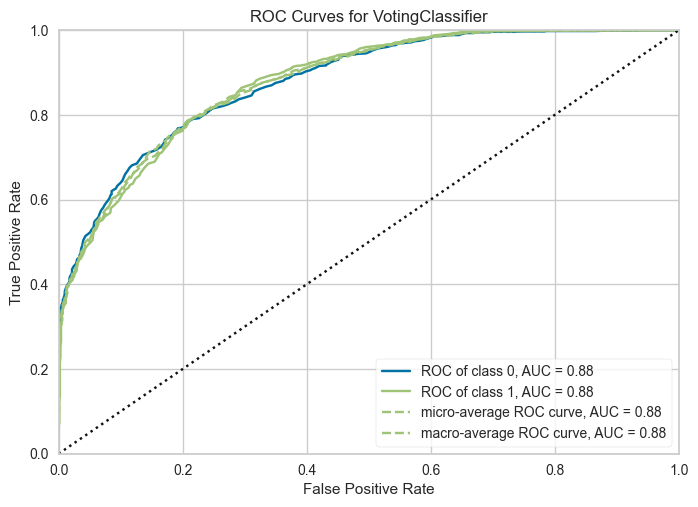

In [59]:
plot_model(blended1)

In [60]:
pred_holdout = predict_model(blended2)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7863,0.8739,0.8549,0.7711,0.8109,0.5668,0.5708


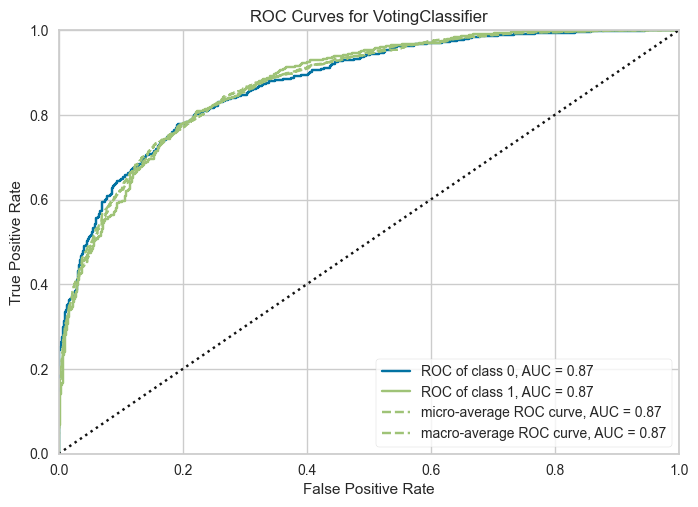

In [61]:
plot_model(blended2)

In [62]:
pred_holdout = predict_model(blended3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7770,0.8615,0.8425,0.7651,0.8019,0.5482,0.5515


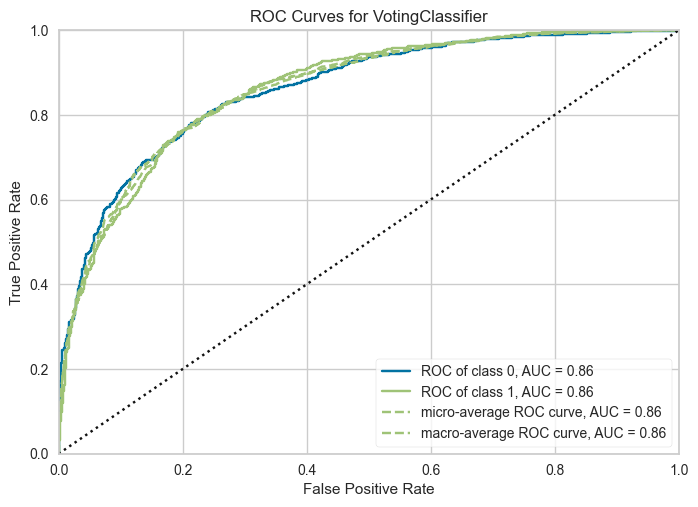

In [63]:
plot_model(blended3)

In [64]:
pred_holdout = predict_model(blended4)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7916,0.8769,0.8566,0.7773,0.8150,0.5778,0.5814


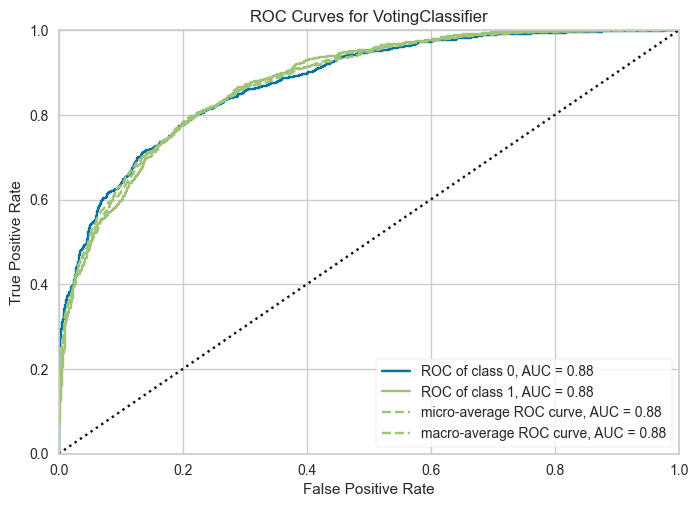

In [65]:
plot_model(blended4)

### 결과 저장

In [66]:
final_model = finalize_model(blended1)
predictions = predict_model(final_model, data = test)
predictions.loc[predictions['Label'] == 0, 'Score'] = 1 - predictions.loc[predictions['Label'] == 0, 'Score']
submission = pd.read_csv('./data/sample_submission.csv')
sub = predictions['Score']
submission['nerdiness'] = sub
submission.to_csv("./submit/submit15_1.csv", index = False)

In [67]:
final_model = finalize_model(blended2)
predictions = predict_model(final_model, data = test)
predictions.loc[predictions['Label'] == 0, 'Score'] = 1 - predictions.loc[predictions['Label'] == 0, 'Score']
submission = pd.read_csv('./data/sample_submission.csv')
sub = predictions['Score']
submission['nerdiness'] = sub
submission.to_csv("./submit/submit15_2.csv", index = False)

In [68]:
final_model = finalize_model(blended3)
predictions = predict_model(final_model, data = test)
predictions.loc[predictions['Label'] == 0, 'Score'] = 1 - predictions.loc[predictions['Label'] == 0, 'Score']
submission = pd.read_csv('./data/sample_submission.csv')
sub = predictions['Score']
submission['nerdiness'] = sub
submission.to_csv("./submit/submit15_3.csv", index = False)

In [69]:
final_model = finalize_model(blended4)
predictions = predict_model(final_model, data = test)
predictions.loc[predictions['Label'] == 0, 'Score'] = 1 - predictions.loc[predictions['Label'] == 0, 'Score']
submission = pd.read_csv('./data/sample_submission.csv')
sub = predictions['Score']
submission['nerdiness'] = sub
submission.to_csv("./submit/submit15_4.csv", index = False)